In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [2]:
!ls /content/german-traffic-signs #look into data inside 'german-traffic-signs'

signnames.csv  test.p  train.p	valid.p


# New Section

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import random
 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
 
from keras.models import Model

import pickle
import cv2
 
 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline

In [4]:
np.random.seed(0)

In [5]:
# 'with' is used whenever we wish to execute two operations as a pair and have a block of code in between
# and invoke a block of code in between. So in our case, we will open a file and manipulate it.

#TODO: Load train data
with open('/content/german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

#TODO: Load validation data
with open('/content/german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# TODO: Load test data
with open('/content/german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [6]:
print(type(train_data))
print(type(val_data))
print(type(test_data))

<class 'dict'>
<class 'dict'>
<class 'dict'>


In [7]:
# Split out features and labels

# The feature key corresponds to values of training, images and pixel representation, whereas the
# labels, well, intuitively its value corresponds to an array of labels which pretty much label each
# training image as belonging to some class. It helps the neural network learn a function that properly
# classifies the input data.

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [8]:
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


This gives us a good idea of how our data is structured.
We see that the shape of our training data set, as we can see, we only have 34799 images in our training sets where each image has dimensions of 32 by 32 pixels and also each one having a depth of 3.

The reason for this is that while our images were great scaled and therefore only had a depth of one hour traffic sign, images are in our RGB format and therefore have an additional depth for each of the three color channels or red, green and blue.

In [9]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [10]:
# let's plot and analyze our data so we can visualize and see how many traffic sign images
# are present from each class. First load the dataset.

data = pd.read_csv('german-traffic-signs/signnames.csv')

In [11]:
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


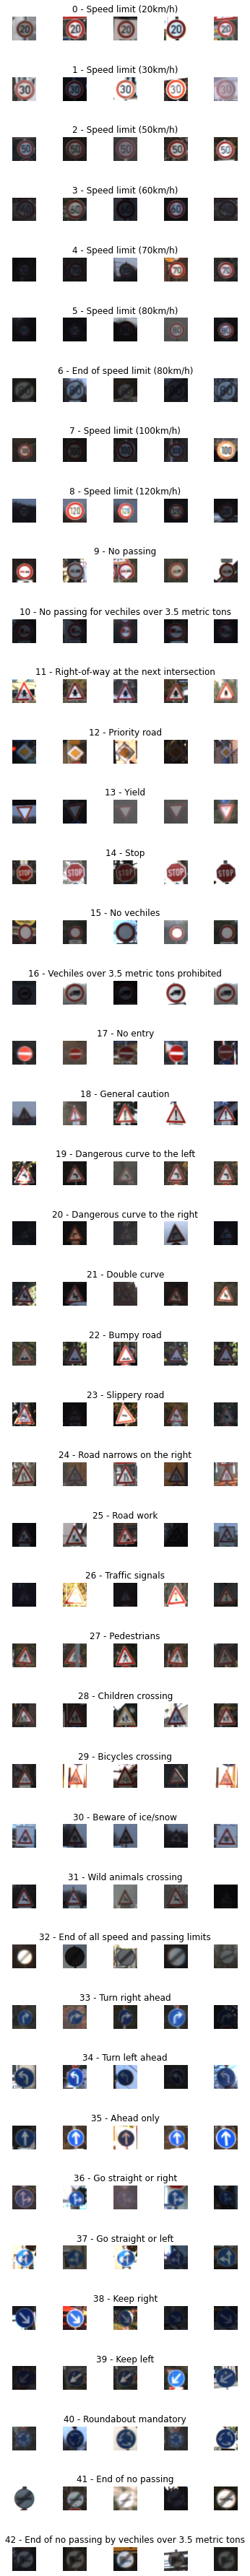

In [12]:
num_of_samples=[]
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
  for j, row in data.iterrows():  # iterate over our data data and what this
                                  # actually allows us to do is iterate over our entire
                                  # data frame rows as index and series pairs.
    x_selected = X_train[y_train == j]

#We're still grabbing the correct image for every column I and J that's iterated through the grid.
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:

#add a hyphen to our title plus hyphen.And another plus, and for each row
# that we're iterating through, we will access the sign and name of sign 
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


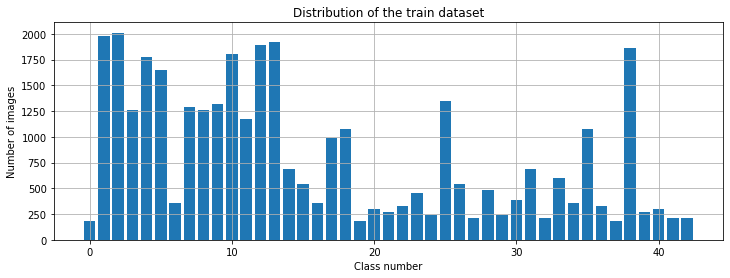

In [13]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.grid()
plt.show()

(32, 32, 3)
36


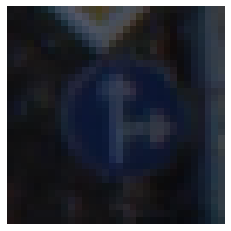

In [14]:
# Our traffic sign data set is a little more complex.The traffic sign images have RGB channels,
# meaning they have a depth of three and they contain various signs with a variety of backgrounds
# and lighting conditions. They're not all black  Essentially, each one of them contains a 
# unique extra features that make it more difficult to classify them. Therefore,we can preprocessed
# these images to make it easier for our network to classify them.So,we will import our open source
# computer vision library KVI tool as a tool for manipulating over images.


import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


The shape of the image, which is currently 32 pixels by 32 with a depth of 3, and shows us that we have a go straight or right side, which have a label of 36, as you would see from here.

This is further confirmation that the label value at each index of the labels is arry is consistent with the traffic sign at the same index of the corresponding X dataset arry.

(32, 32)


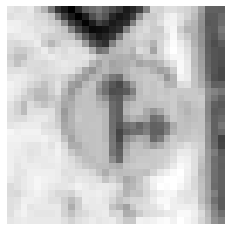

In [15]:
# Now write a function. This function will converts an RGB image into a 
# grayscale image.This greyscale conversion is important for two main reasons, the first being
# that one distinguishing between traffic signs. Color is not a very significant feature to look for.
# The lighting in our image varies and many of the traffic signs of similar colors reinforcing that it
# is not a very relevant piece of information, the features of the traffic signs that really matter are
# the edges of the curves, the shape inside of it.That's what the network should focus on.


def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

#Actually it does convert to grayscale but opposite colours.
#It's necessary to use the bitwise_not function.
img = cv2.bitwise_not(grayscale(X_train[1000]))
plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

This shows us that our image has been great, scaled appropriately, it is now a two dimensional array of pixel intensity values. It does not have a depth.

(32, 32)


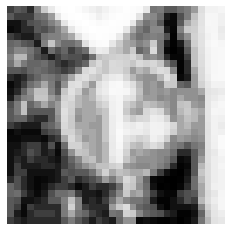

In [16]:
#Histogram equalization aims to standardize the lighting and all our images.
#after histogram equalization, all images will have a similar lighting effect.
def equalize(img):
  img = cv2.equalizeHist(img)
  return img
img = equalize(img)
#img = cv2.bitwise_not(equalize(img))
plt.imshow(img,cmap=plt.get_cmap('Greys'))
plt.axis("off")
print(img.shape)


In [17]:
# now that we visualize the effect of our pre processing techniques, we need to apply these techniques
# to all of our images so we'll define a function that does so, which will be used
# to process our entire data dataset.

def preprocess(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))


(34799, 32, 32)


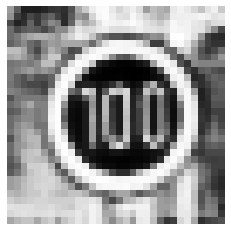

In [18]:
#random image
plt.imshow(X_train[random.randint(0, len(X_train) - 1)],cmap=plt.get_cmap('Greys'))
plt.axis("off")
print(X_train.shape)

In [19]:
# The next step in preparing our data for use any convolutional network is to add depth to our
# data.At the moment, each image is two dimensional.It does not have a depth.And as you might
# recall, the way convolutional networks work is by applying a filter to the channels
# of the image that's being viewed in the case of grayscale images.
# There is one channel present therefore our data must reflect the presence of the steps.
# And so by adding this depth, our data will be in the desired shape to be used as an input
# for the convolutional layer.

#reshaping
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)


In [20]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


Everything works out as expected, our data now have a depth of 1 and are properly formatted for our network.

The final step in preparing our data for users to one hot encode our data labels.

In [21]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 


(15, 32, 32, 1)


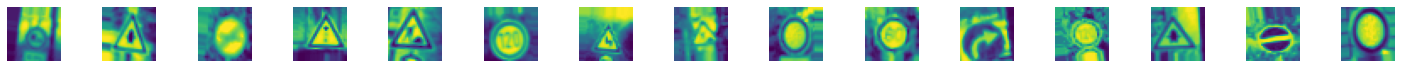

In [22]:
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [23]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [24]:
# create model
 
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu')) #adding extra convolutional layers.
# This can help our network extract features more effectively and can also lead to improved accuracy.



  model.add(MaxPooling2D(pool_size=(2, 2))) # pooling will scale down all the feature maps from the convolutional layer
# into a small, abstracted, generalised representation, which ultimately helps to avoid overfitting
# and reduces the amount of parameters that are being adjusted.
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

# now going to take our convoluted data and feed it into the fully
# connected layer as a one dimensional array.So originally it's going to go into
# the front and layer as a 6 by 6 by 15, although it will reshape 
# it into a one dimensional array, a shape five hundred and forty.
# So five hundred and forty nodes will be fed into our multilayered Perceptron 
# and our data is now ready to be fed into the full looking after layer.


  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

#compile model
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

  

In [25]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
#train model
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=100),
                            steps_per_epoch=X_train.shape[0]/100,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
347/347 [==============================] - 313s 897ms/step - loss: 2.3936 - accuracy: 0.3280 - val_loss: 0.7850 - val_accuracy: 0.7558
Epoch 2/10
347/347 [==============================] - 310s 892ms/step - loss: 1.0946 - accuracy: 0.6620 - val_loss: 0.2961 - val_accuracy: 0.9018
Epoch 3/10
347/347 [==============================] - 310s 892ms/step - loss: 0.7100 - accuracy: 0.7805 - val_loss: 0.1790 - val_accuracy: 0.9467
Epoch 4/10
347/347 [==============================] - 310s 891ms/step - loss: 0.5426 - accuracy: 0.8305 - val_loss: 0.1192 - val_accuracy: 0.9649
Epoch 5/10
347/347 [==============================] - 310s 891ms/step - loss: 0.4378 - accuracy: 0.8622 - val_loss: 0.0710 - val_accuracy: 0.9789
Epoch 6/10
347/347 [==============================] - 310s 892ms/step - loss: 0.3743 - accuracy: 0.8845 - val_loss: 0.0621 - val_accuracy: 0.9814
Epoch 7/10
347/347 [==============================] - 311s 893ms/step - loss: 0.3252 - accuracy: 0.8969 - val_loss: 0.0663 -

Text(0.5, 0, 'epoch')

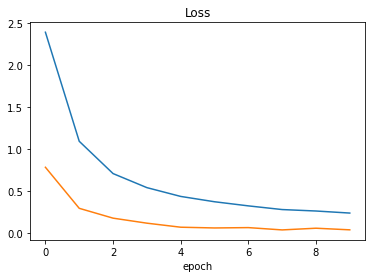

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

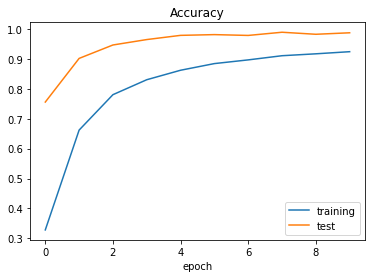

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [29]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)


In [30]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.12814368307590485
Test accuracy: 0.9643705487251282


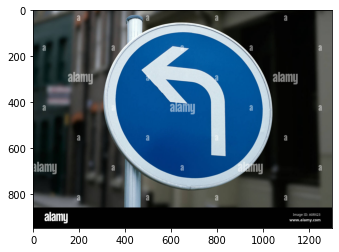

In [31]:
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


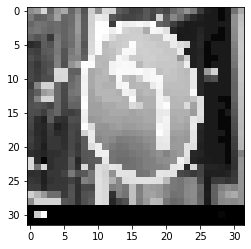

In [32]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)


In [33]:
img = img.reshape(1, 32, 32, 1)
prediction = np.argmax(model.predict(img), axis=-1) 
print("predicted sign: "+ str(prediction))

predicted sign: [34]
